# Optimización de portfolio

Primero instalamos vía pip la librería `yfinance`, que no está disponible en Google Colab, y es una herramienta que permite descargar y manipular datos financieros de Yahoo Finance. Con esta librería se pueden obtener precios históricos de acciones, índices, criptomonedas, bonos, etc. y realizar análisis técnicos, como gráficos, media móvil, volatilidad, entre otros. Además, también se pueden descargar información sobre dividendos y splits de acciones.

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import datetime
from typing import List

import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib as mpl

# configure matplotlib
%matplotlib inline  
mpl.rcParams["figure.figsize"] = (15, 10)
plt.style.use("seaborn-whitegrid")

symbols = [
    "TSM", 
    "TSLA", 
    "MTN", 
    "IDXX", 
    "FIGS"
]

start_date = datetime.date(2022, 1, 1)

Aquí hemos definido algunos imports, configuraciones y variables que utilizaremos en el resto del notebook.

- `datetime` se utiliza para trabajar con fechas y horas.
- `scipy.optimize.minimize` es una función de la biblioteca Scipy para minimizar una función dada.

La variable `symbols` contiene una lista de códigos de acciones (símbolos) para varias compañías tecnológicas populares. Finalmente, `start_date` es un objeto de tipo `datetime.date` que representa la primera fecha a partir de la cual vamos a traer datos. 

In [ ]:
def generate_stocks(symbols: List[str], start: datetime.date): 
    stocks = yf.download(
        symbols, 
        start=start, 
        end=datetime.datetime.today(), 
        progress=False
    )['Close']
    return stocks

def get_returns(stocks: pd.DataFrame):
    returns = np.log(stocks / stocks.shift(1)).dropna(how="any")
    return returns

def generate_weights(n, equal: bool=None):
    if equal: 
        w = np.ones(n) / n
        return w
    w = np.random.rand(n)
    w_norm = w / w.sum()
    return w_norm

def get_portfolio_return(w: np.array, returns: pd.DataFrame):
    return np.sum(returns.mean()*w)

def get_risk(w: np.array, returns: pd.DataFrame): 
    return np.sqrt(w.T@returns.cov()@w)

Veamos lo que hacen cada una de estas funciones:

- `generate_stocks`: esta función toma una lista de símbolos de acciones y una fecha inicial y descarga los datos de cierre de Yahoo Finance para esas acciones. Utiliza el método `yf.download()` para descargar los datos y el parámetro `progress=False` para evitar la impresión de mensajes de progreso. La función devuelve solo la columna 'Close' de los datos descargados.

- `get_returns`: esta función toma un DataFrame de acciones y calcula los retornos diarios utilizando la fórmula logarítmica de retorno. Utiliza el método `np.log()` para calcular los retornos y el método `dropna()` para eliminar las filas con valores faltantes. La función devuelve el DataFrame de retornos.

- `generate_weight`: esta función genera pesos aleatorios para cada acción, recibe como argumento el número de acciones a considerar. Utiliza la función `np.random.rand()` para generar los pesos aleatorios y luego normaliza los pesos dividiéndolos entre la suma total de los pesos. La función devuelve el DataFrame de pesos normalizados. Si `equal` es `True`, entonces todos los pesos son el mismo.

- `get_portfolio_return`: esta función toma un array de pesos y un DataFrame de retornos y calcula el retorno diario esperado. Utiliza el método `mean()` de Pandas para calcular los retornos medios de cada acción y luego los multiplica por los pesos correspondientes. La función devuelve el retorno diario esperado. 

- `get_risk`: esta función toma un array de pesos y un DataFrame de retornos y calcula el riesgo asociado a esos pesos. Utiliza el método `cov()` de Pandas para calcular la matriz de covarianza de los retornos y luego multiplica la matriz de covarianza por los pesos. La función devuelve el riesgo calculado. Si $w$ es el vector de pesos y $\Omega = (\sigma)_{ij}$ la [matrix de covarianza](https://en.wikipedia.org/wiki/Covariance_matrix) de retornos, el riesgo se calcula como 

$$
\text{riesgo} = \sqrt{w^T \Omega w} = \sqrt{\sum_{i=1}^{n} \sum_{j=1}^n w_iw_j\sigma_{ij}}
$$

In [ ]:
stocks = generate_stocks(symbols, start_date)
returns = get_returns(stocks)

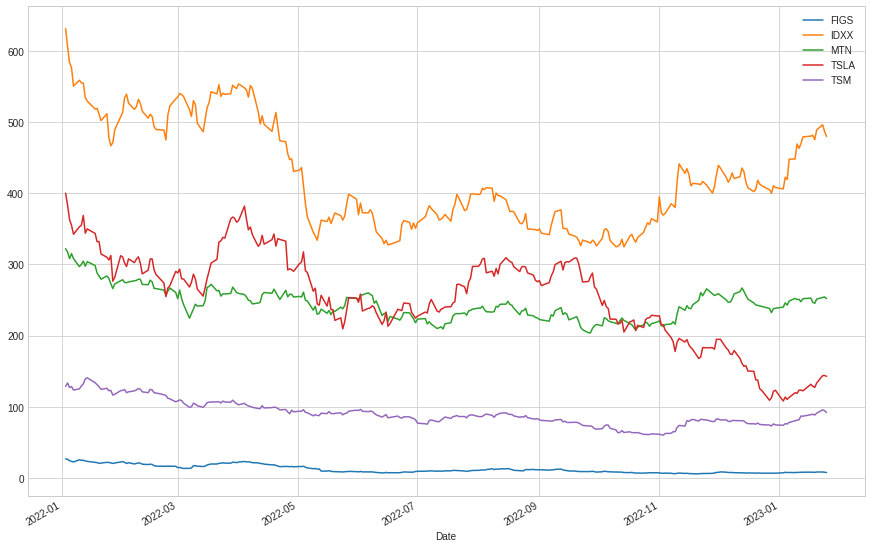

In [ ]:
stocks.plot()

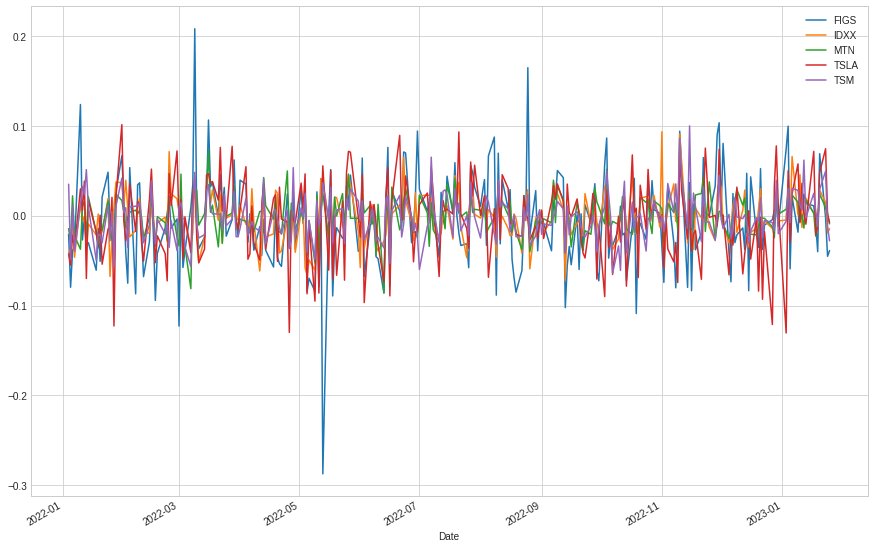

In [ ]:
returns.plot()

## Buscamos un vector de pesos óptimo que minimice el riesgo

In [ ]:
def get_optimal_portfolio_weights(returns):
    # The constraints
    cons = (
        {
            "type": "eq", 
            "fun": lambda w: np.sum(w) - 1
        }, 
        {
            "type": "ineq", 
            "fun": lambda w: np.sum(returns.mean()*w) - returns.mean().mean()
        }
    ) 
    
    
    # Every stock can get any weight from 0 to 1
    bounds = tuple((0,1) for x in range(returns.shape[1])) 
    
    # Initialize the weights with an even split
    # In out case each stock will have 10% at the beginning
    guess = [1./returns.shape[1] for x in range(returns.shape[1])]
    
    objective = lambda w: get_risk(w, returns) 

    optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)

    s = pd.Series(
        optimized_results.x, 
        index=returns.columns
    )

    print("Vector de pesos óptimo")
    print(s)
    print(s.sum())

    return s

## Visualizaciones

In [ ]:
def generate_plot(ax, returns, n):

    # individual stocks
    individual_returns = returns.mean()
    individual_risks = returns.std()
    
    # random portfolios
    portfolio_returns = []
    portfolio_risks = []
    for _ in range(n):
        w = generate_weights(returns.shape[1])
        portfolio_returns.append(get_portfolio_return(w, returns))
        portfolio_risks.append(get_risk(w, returns))

    # equally distributed portfolio
    w_eq = generate_weights(returns.shape[1], equal=True)
    eq_portfolio_returns = get_portfolio_return(w_eq, returns)
    eq_portfolio_risk = get_risk(w_eq, returns)

    # optimal portfolio
    w_opt = get_optimal_portfolio_weights(returns)
    opt_portfolio_returns = get_portfolio_return(w_opt, returns)
    opt_portfolio_risk = get_risk(w_opt, returns)

    ax.scatter(individual_returns, individual_risks, label="individual stocks", s=50)
    for i, col in enumerate(returns.columns):
        ax.annotate(col, (individual_returns[i], individual_risks[i]))
    ax.scatter(portfolio_returns, portfolio_risks, label="random portfolio", s=100)
    ax.scatter(eq_portfolio_returns, eq_portfolio_risk, label="eq. dist. portfolio", s=100)
    ax.scatter(opt_portfolio_returns, opt_portfolio_risk, label="optimal portfolio", s=200)

    ax.legend()
    ax.set_xlabel("Expected daily return")
    ax.set_ylabel("risk")
    ax.set_title("Return vs risk")

    return ax

Vector de pesos óptimo
FIGS    2.754061e-17
IDXX    2.103672e-01
MTN     4.780323e-01
TSLA    0.000000e+00
TSM     3.116005e-01
dtype: float64
1.0


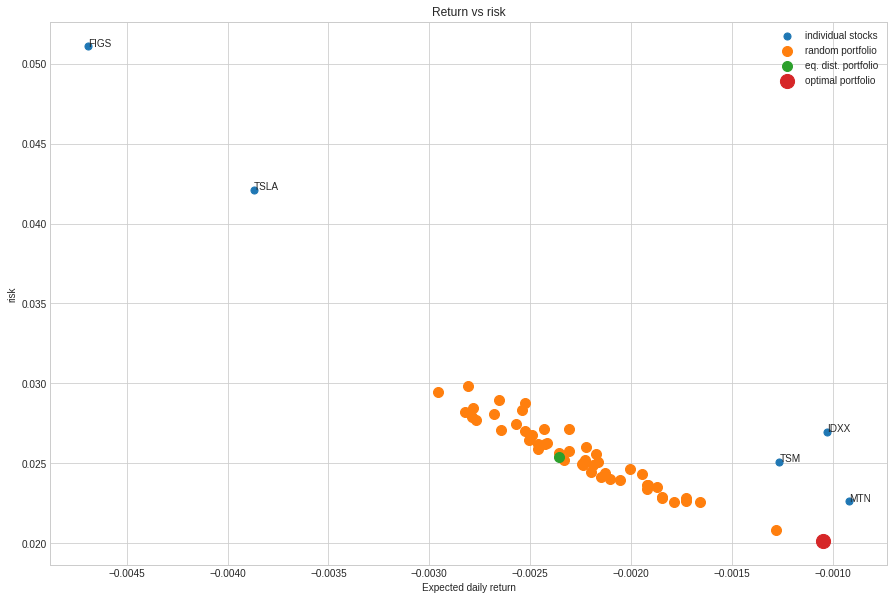

In [ ]:
fig, ax = plt.subplots()
generate_plot(ax, returns, n=50)